Now that we studied the Q-Learning algorithm, let’s implement it from scratch and train our Q-Learning agent in Taxi-3 environment:


*Q-Learning* **is the RL algorithm that**:

- Trains *Q-Function*, an **action-value function** that encoded, in internal memory, by a *Q-table* **that contains all the state-action pair values.**

- Given a state and action, our Q-Function **will search the Q-table for the corresponding value.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-function-2.jpg" alt="Q function"  width="100%"/>

- When the training is done,**we have an optimal Q-Function, so an optimal Q-Table.**

- And if we **have an optimal Q-function**, we
have an optimal policy, since we **know for, each state, the best action to take.**

### Import the packages

In [12]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import imageio

### QAgent Class:
Is initialized with the environment *env* and the necessary hyper-parameters (*alpha*, *gamma*, *epsilon*, etc)

This class implements the most important steps of **Q-Learning** Algorithm:
-  Q-Table initialization
    -  Q-Table shape=(n_states * n_actions)

-  Epsilon-greedy policy as an acting policy
   - With *probability 1-ɛ* : **we do exploitation** (i.e. our agent selects the action with the highest state-action pair value).

   - With *probability ɛ*: we do **exploration** (trying a random action).

-  Greedy-policy as an updating policy
   - using Bellman equation *Q(s,a) + lr[R(s,a) + gamma * max Q(s',a') - Q(s,a)]*


In [13]:
class QAgent:

    def __init__(self, env, alpha, gamma, max_epsilon, min_epsilon, decay_rate):
       
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        # --> une matrice (états × actions), initialisée à zéro

        # hyper-parameters
        self.alpha = alpha                      # learning rate
        self.gamma = gamma                      # discount factor
        self.max_epsilon = max_epsilon          # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.decay_rate =  decay_rate           # Exponential decay rate for exploration prob
    

    # get action using epsilon greedy policy
    def get_action(self, state, epsilon):
        # Randomly generate a number between 0 and 1
        random_num = np.random.uniform(0, 1)
    
        # if random_num > epsilon --> exploitation
        if random_num > epsilon:
            # Take the action with the highest value given a state
            action = np.argmax(self.q_table[state])
    
        # else --> exploration
        else:
            action = self.env.action_space.sample()

        return action


    def update_parameters(self, state, action, reward, next_state):
        """Q-learning update"""
        # Q-learning formula
        # Update Q(s,a):= Q(s,a) + lr [R(s,a)  + gamma * max Q(s',a') - Q(s,a)]
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)

        # update the q_table
        self.q_table[state, action] = new_value


### The training loop:
The training is based on *Temporal Difference (TD) learning* where the Q-Table is updated after each step

- For episode in the total of training episodes:

  - Reduce epsilon (since we need less and less exploration)
  - Reset the environment

  - For step in max timesteps:
    - Choose the action $a$ using epsilon greedy policy
    - Take the action ($a$) and observe the outcome state(s') and reward (r)
    - Update the Q-value Q($s$,$a$) using Bellman equation Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    - If done, finish the episode
    - Our next state is the new state

In [14]:
def train(n_training_episodes, env, agent):

    episode_rewards = []
    episode_penalties = []
    episode_steps = []

    for episode in tqdm(range(n_training_episodes)):

        total_rewards_ep = 0
        total_penalties_ep = 0
        total_steps_ep = 0

        # Réduction progressive d’epsilon (moins d’exploration au fil du temps)
        epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.decay_rate * episode)

        # Réinitialiser l’environnement
        state, info = env.reset()
        terminated = False
        truncated = False
        done = False

        # Boucle d’un épisode
        while not done:

            # --- Choisir une action avec la stratégie epsilon-greedy ---
            action = agent.get_action(state, epsilon)

            # --- Exécuter l’action et observer la nouvelle situation ---
            next_state, reward, terminated, truncated, info = env.step(action)

            # --- Mettre à jour les récompenses et compteurs ---
            total_rewards_ep += reward
            total_steps_ep += 1

            if reward == -10:
                total_penalties_ep += 1

            # --- Mettre à jour la Q-table selon l’équation de Bellman ---
            agent.update_parameters(state, action, reward, next_state)

            # Vérifier si l’épisode est terminé
            done = terminated or truncated

            # Passer à l’état suivant
            state = next_state

        # Sauvegarder les statistiques de l’épisode
        episode_rewards.append(total_rewards_ep)
        episode_steps.append(total_steps_ep)
        episode_penalties.append(total_penalties_ep)

    return episode_rewards, episode_steps, episode_penalties


### Hyper-Parameters

The exploration related hyper-paramters are some of the most important ones.
- We need to make sure that our agent **explores enough of the state space** to learn a good value approximation. To do that, we need to have progressive decay of the epsilon.
- If you decrease epsilon too fast (too high decay_rate), **you take the risk that your agent will be stuck**, since your agent didn't explore enough of the state space and hence can't solve the problem.

In [15]:
# Environment
env = gym.make("Taxi-v3")

# Training parameters
n_training_episodes = 1000  # Total training episodes
alpha= 0.7                   # Learning rate

# Environment parameters
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005           # Exponential decay rate for exploration prob

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

### Train the Q-Agent on Taxiv3 Environment

In [16]:
env=gym.make("Taxi-v3", render_mode="rgb_array")

agent=QAgent(env, alpha, gamma, max_epsilon, min_epsilon, decay_rate)

episode_rewards,episode_steps, episode_penalties=train(n_training_episodes, env,agent)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 257.69it/s]


### Plot the training result
- episode_rewards: the cumulative rewards progression over all episodes (should be increased over time)
- episode_steps: the required step per episode (should be decreased over time)
- episode_penalties: the total penalties per episode (should be decreased over time)

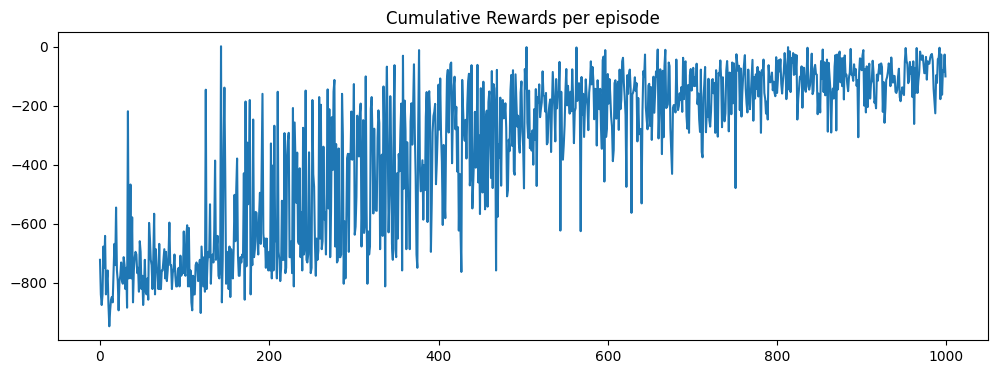

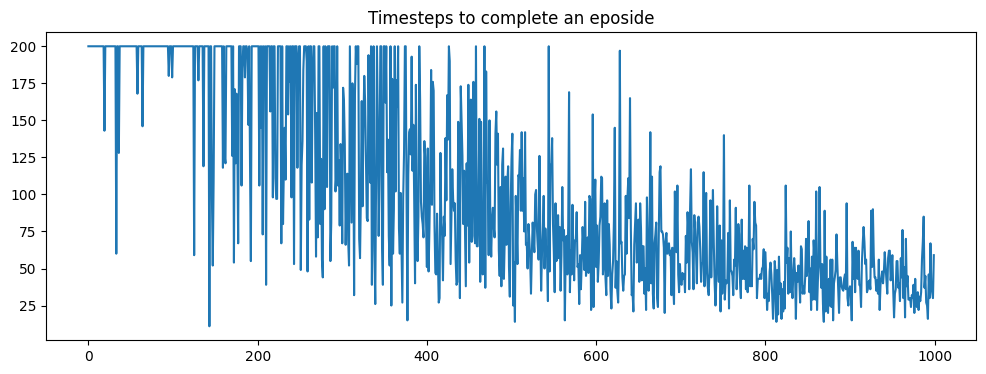

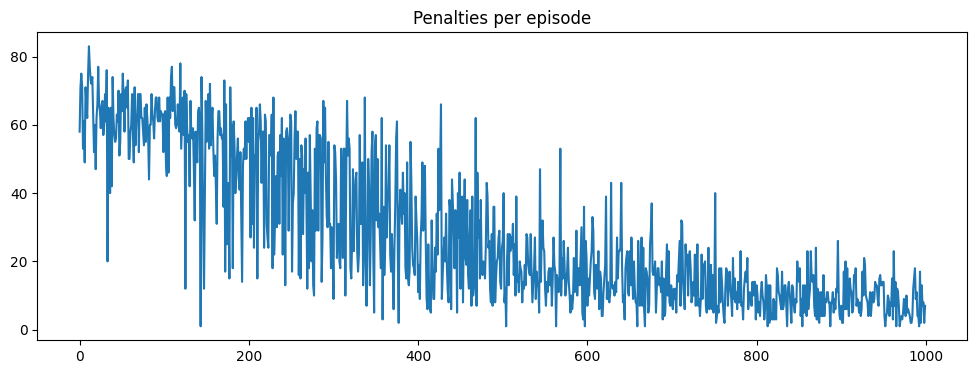

In [17]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per episode")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete an eposide")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per episode")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Evaluate the QAgent after training

In [18]:
def evaluate_agent(env, agent, n_eval_episodes):

    episode_rewards = []
    episode_penalties = []
    episode_steps = []

    for episode in tqdm(range(n_eval_episodes), desc="Evaluating agent"):
        # Reset environment
        state, info = env.reset()
        terminated = False
        truncated = False
        done = False

        total_rewards_ep = 0
        total_penalties_ep = 0
        total_steps_ep = 0

        # Run one evaluation episode
        while not done:
            # Always exploit (epsilon=0) → choose best action
            action = agent.get_action(state, epsilon=0)

            # Take action and observe result
            next_state, reward, terminated, truncated, info = env.step(action)

            total_rewards_ep += reward
            total_steps_ep += 1
            if reward == -10:
                total_penalties_ep += 1

            done = terminated or truncated
            state = next_state

        # Save episode stats
        episode_rewards.append(total_rewards_ep)
        episode_steps.append(total_steps_ep)
        episode_penalties.append(total_penalties_ep)

    # Compute average and std deviation of rewards
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward, episode_rewards, episode_steps, episode_penalties


In [19]:
mean_reward, std_reward,episode_rewards,episode_steps, episode_penalties=evaluate_agent(env,agent, 1000)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Evaluating agent: 100%|██████████| 1000/1000 [00:00<00:00, 2721.51it/s]

Mean_reward=7.52 +/- 9.64


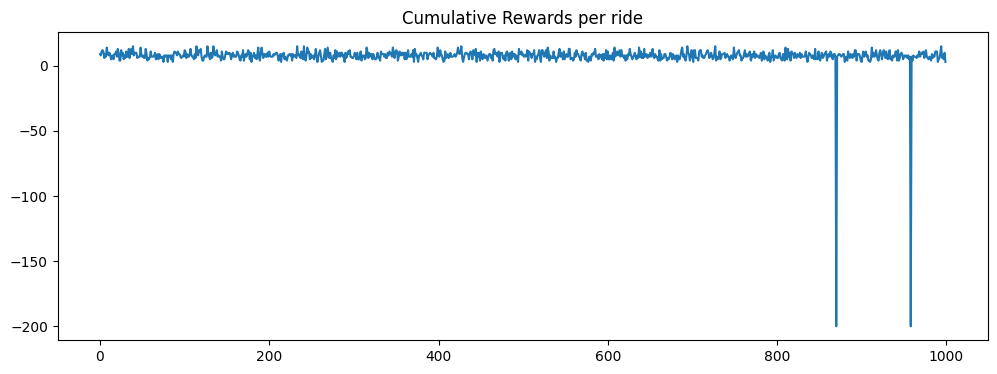

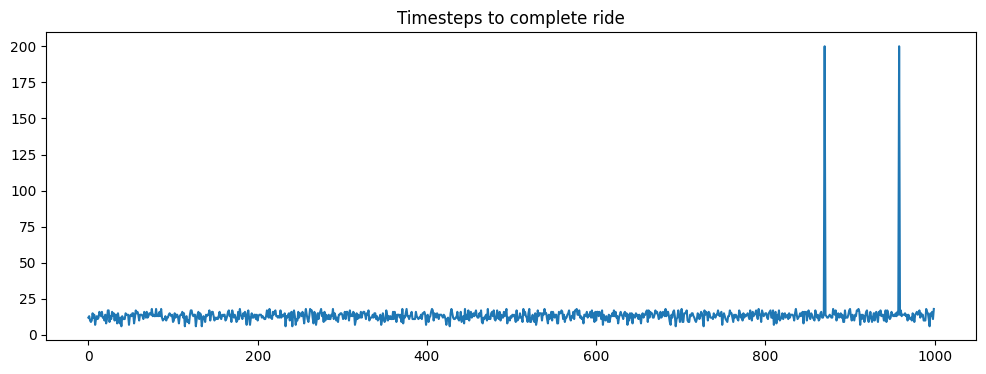

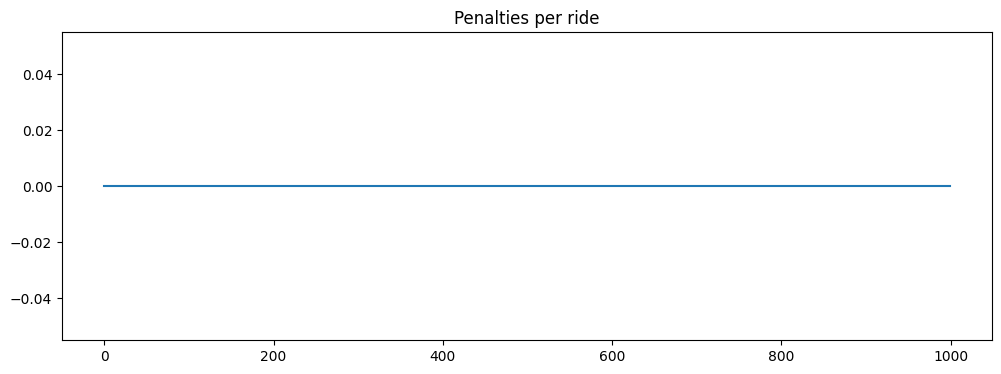

In [20]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Record a simulation as a video

In [21]:
def record_video(env, agent, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param agent:  agent within its Qtable
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(agent.q_table[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [22]:

from base64 import b64encode
from IPython.display import HTML

# generate the video
video_path = "./replay.mp4"
record_video(env, agent, video_path, 1)

# Show video
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=400 controls>      <source src="%s" type="video/mp4"></video>""" % data_url)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
